In [18]:
import tensorflow as tf
# import tensorflow_datasets as tfds
# from keras.layers import Layer, Input
# from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose
from tensorflow.keras.utils import load_img
# from keras.models import Model, Sequential
# from keras.layers import Concatenate, UpSampling2D
# import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Load Images


In [4]:
path = "C:/Users/saish/Desktop/8th sem/CSE 441 Industry Project/Semantic segmentation dataset"
listDir = []
for dir in os.listdir(path):
    if dir != "classes.json":
        listDir.append(dir)

listDir = sorted(listDir)

In [6]:
listDir

['Tile 1',
 'Tile 2',
 'Tile 3',
 'Tile 4',
 'Tile 5',
 'Tile 6',
 'Tile 7',
 'Tile 8']

In [13]:
def loadImg(path, dirTile):
    input_img, mask_img = [], []
    path = os.path.join(path, dirTile)
    inpDir, maskDir = os.listdir(path)

    imgDirs = sorted(os.listdir(os.path.join(path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(path, maskDir)))

    for imgDir in imgDirs:
        imgDir = os.path.join(path, inpDir, imgDir)
        img = load_img(imgDir, target_size = (224, 224))
        img = tf.convert_to_tensor(img, dtype = tf.float32) / 255.0
        input_img.append(img)

    for mask_imgDir in mask_imgDirs:
        mask_imgDir = os.path.join(path, maskDir, mask_imgDir)
        mask = load_img(mask_imgDir, target_size = (224, 224))
        mask = tf.convert_to_tensor(mask, dtype = tf.float32) / 255.0
        mask_img.append(mask)

    return input_img, mask_img

In [14]:
def loadData(path = path, listDir = listDir):
    imgs_data, masks_data = [], []
    for dirTile in listDir:
        input_imgs, mask_imgs = loadImg(path, dirTile)

        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)
    return imgs_data, masks_data

In [15]:
input_imgs, mask_imgs = loadData()

NameError: name 'load_img' is not defined

(-0.5, 223.5, 223.5, -0.5)

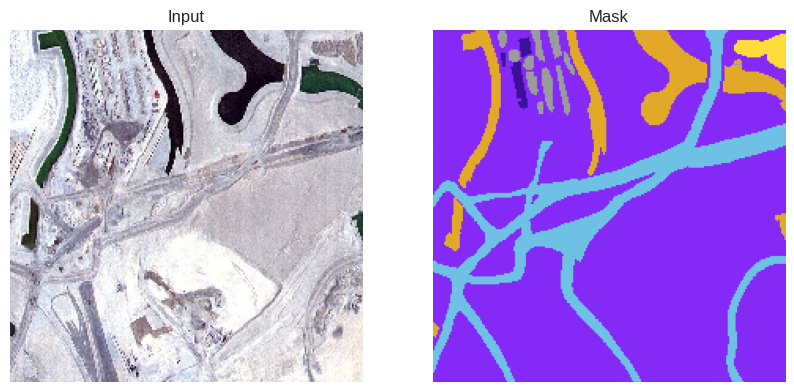

In [39]:
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(input_imgs[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_imgs[0])
plt.axis("off")

In [40]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_masks, test_masks = train_test_split(input_imgs, mask_imgs,
                                                                  test_size = 0.2,
                                                                  shuffle = True,
                                                                  random_state = 42)

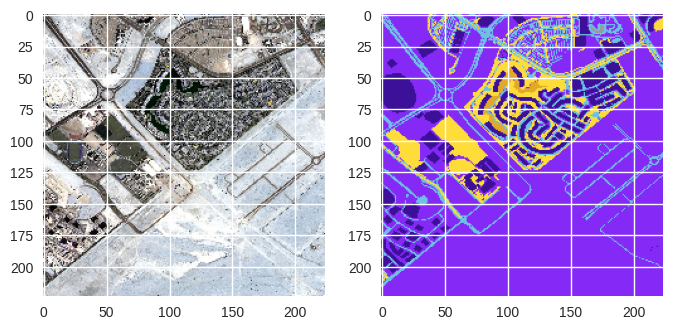

In [41]:
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[1])

plt.subplot(1, 2, 2)
plt.imshow(train_masks[1])

In [42]:
train_data = np.array(list(zip(train_imgs, train_masks)))
test_data = np.array(list(zip(test_imgs, test_masks)))

# Model (from Scratch)


In [43]:
def Conv(x, dropout, filters):
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = Dropout(dropout)(x)
  pool = MaxPooling2D(pool_size = (2, 2))(x)

  return x, pool

def UpSample(x, skip_connect, dropout, filters):
  x = Concatenate(axis = -1)([skip_connect, UpSampling2D(size = (2, 2))(x)])
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = Dropout(dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)

  return x


In [44]:
def UNet(x, dropout, conv = [32, 64, 128, 256, 512]):

  # encoder
  conv1, pool1 = Conv(x, dropout, conv[0]) # 224 -> 112
  conv2, pool2 = Conv(pool1, dropout, conv[1]) # 112 -> 56
  conv3, pool3 = Conv(pool2, dropout, conv[2]) # 56 -> 28
  conv4, pool4 = Conv(pool3, dropout, conv[3]) # 28 -> 14

  conv5 = Conv2D(filters = conv[4], kernel_size = 3, padding = 'same', activation = 'relu')(pool4)
  conv5 = Dropout(dropout)(conv5)
  conv5 = BatchNormalization()(conv5)

  # decoder
  conv6 = UpSample(conv5, conv4, dropout, conv[4]) # 14 -> 28
  conv7 = UpSample(conv6, conv3, dropout, conv[3]) # 28 -> 56
  conv8 = UpSample(conv7, conv2, dropout, conv[2]) # 56 -> 112
  conv9 = UpSample(conv8, conv1, dropout, conv[1]) # 112 -> 224

  # output
  result = Conv2D(filters = 3, kernel_size = 1, padding = 'same', activation = 'sigmoid')(conv9)

  return result

In [45]:
input = Input(shape = (224, 224, 3))
output = UNet(input, dropout = 0.1)

model = Model(inputs = input, outputs = output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 224, 224, 32)         896       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 224, 224, 32)         128       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_20 (Conv2D)          (None, 224, 224, 32)         9248      ['batch_normalization_14

In [46]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [47]:
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [48]:
history = model.fit(np.array(train_imgs), np.array(train_masks),
                    batch_size = 8,
                    epochs = 25,
                    validation_data = (np.array(test_imgs), np.array(test_masks)),
                    callbacks = [earlystopping])

Epoch 1/25
8/8 [==============================] - 293s 33s/step - loss: 0.6536 - accuracy: 0.5332 - val_loss: 0.9681 - val_accuracy: 0.1782
Epoch 2/25
8/8 [==============================] - 255s 32s/step - loss: 0.5807 - accuracy: 0.6131 - val_loss: 1.7044 - val_accuracy: 0.7252
Epoch 3/25
8/8 [==============================] - 254s 32s/step - loss: 0.5655 - accuracy: 0.6090 - val_loss: 0.7466 - val_accuracy: 0.2016
Epoch 4/25
8/8 [==============================] - 262s 33s/step - loss: 0.5511 - accuracy: 0.6546 - val_loss: 0.7935 - val_accuracy: 0.2071
Epoch 5/25
8/8 [==============================] - 256s 32s/step - loss: 0.5469 - accuracy: 0.6393 - val_loss: 0.7302 - val_accuracy: 0.7351
Epoch 6/25
8/8 [==============================] - 256s 32s/step - loss: 0.5389 - accuracy: 0.6696 - val_loss: 0.7529 - val_accuracy: 0.7341
Epoch 7/25
8/8 [==============================] - 256s 32s/step - loss: 0.5353 - accuracy: 0.6703 - val_loss: 0.7327 - val_accuracy: 0.7341


# Result Visualization

<ipython-input-49-76b4d96f0653>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


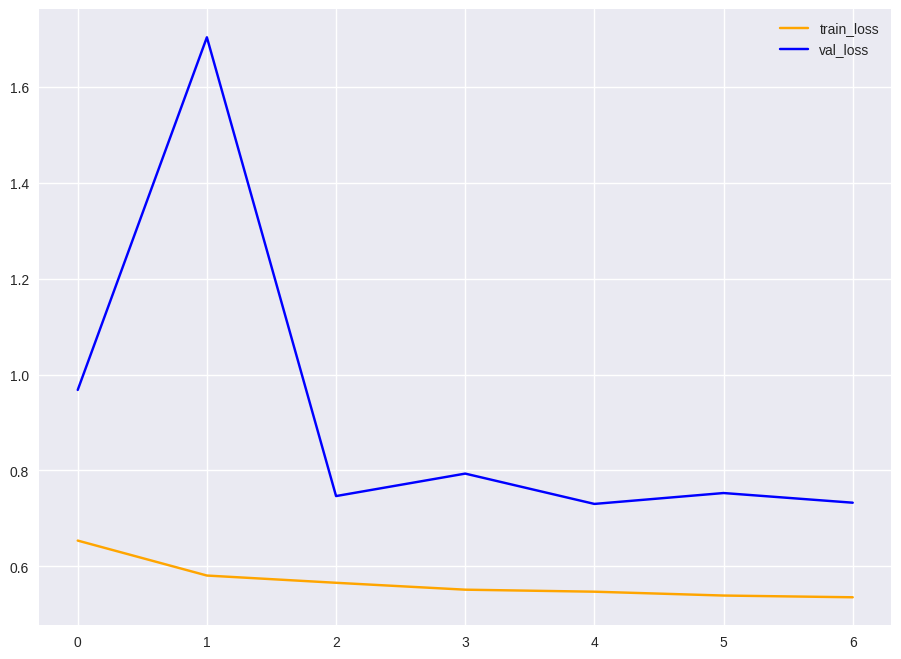

In [49]:
plt.style.use('seaborn')
plt.figure(figsize = (11, 8))
plt.plot(history.history['loss'], c = 'orange', label = 'train_loss')
plt.plot(history.history['val_loss'], c = 'blue', label = 'val_loss')
plt.legend()
plt.show()

<ipython-input-50-eec54a2f5362>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


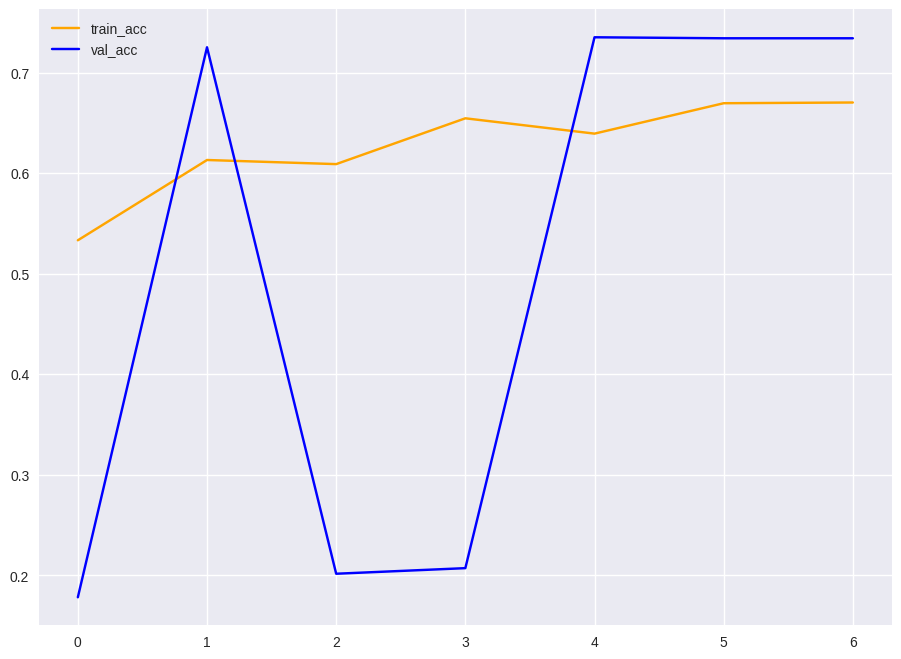

In [50]:
plt.style.use('seaborn')
plt.figure(figsize = (11, 8))
plt.plot(history.history['accuracy'], c = 'orange', label = 'train_acc')
plt.plot(history.history['val_accuracy'], c = 'blue', label = 'val_acc')
plt.legend()
plt.show()

# Predict

In [51]:
images_predict = model.predict(np.array(test_imgs))

1/1 [==============================] - 19s 19s/step


In [52]:
def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize = (12, 7))

    ax[0].set_title('original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")

    ax[1].set_title('predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")

    ax[2].set_title('ground_truth')
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

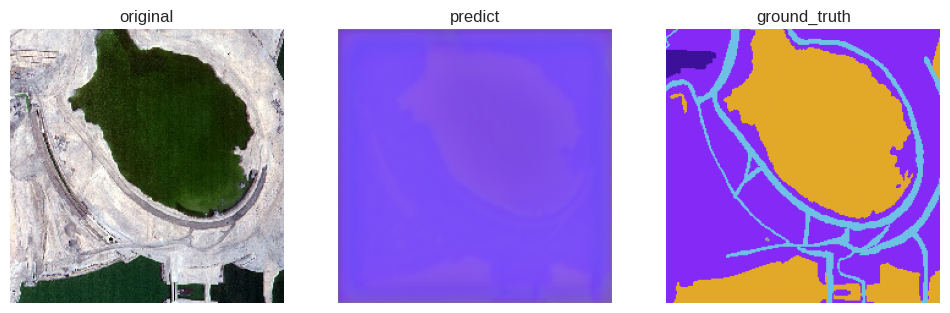

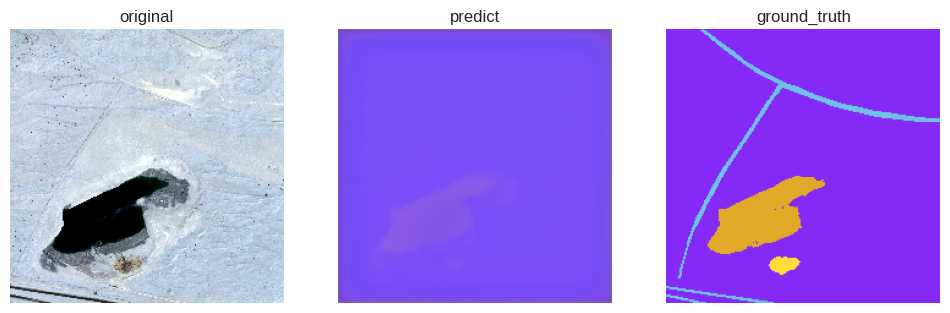

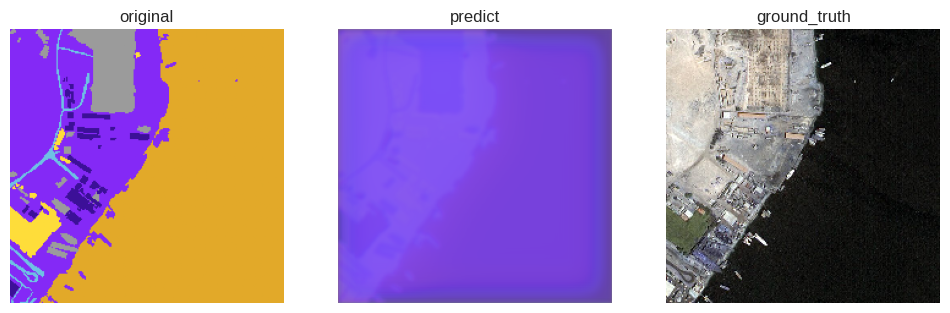

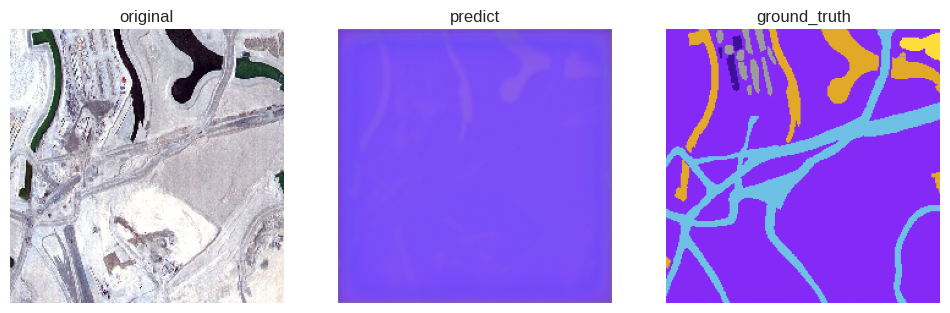

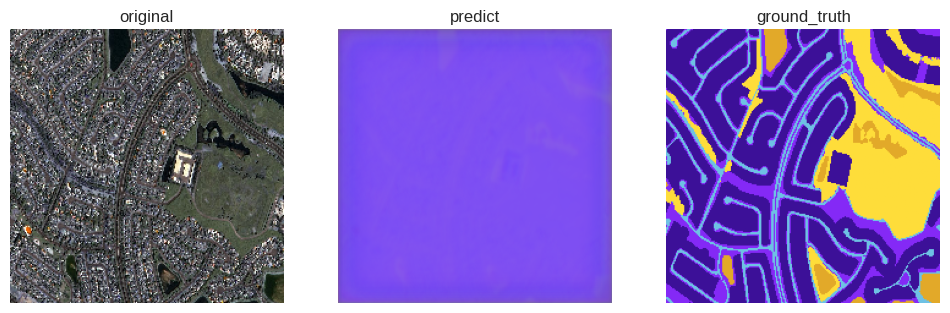

In [53]:
for id in range(5):
    show_result(id)

# Model (Pre-trained)

In [54]:
from keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNetV2(input_shape = (224, 224, 3),
                    include_top = False,
                    weights = 'imagenet')

In [55]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## UNet implement

In [56]:
import keras
def down_path():
    layers = ['block_1_expand_BN',
              'block_2_expand_BN',
              'block_4_expand_BN',
              'block_12_expand_relu',
              'block_16_depthwise_relu']
    outputs = [model.get_layer(layer).output for layer in layers]
    encoder = Model(inputs = model.input, outputs = outputs)
    encoder.trainable = False

    return encoder

def up_path():
    decoder = []
    for filters in [512, 256, 128, 64]:
        block = Sequential([
            Conv2DTranspose(filters = filters, kernel_size = 3, strides = 2, padding = 'same'),
            BatchNormalization(),
            keras.layers.ReLU(),
            Dropout(0.1)
        ])
        decoder.append(block)
    return decoder

def UNetModel(input = Input(shape = (224, 224, 3))):
    encoder = down_path()
    decoder = up_path()

    outputs = encoder(input)

    output = outputs[-1]
    encode_outputs = reversed(outputs[:-1])

    for id, encode_output in enumerate(encode_outputs):
        decode_output = decoder[id](output)
        output = Concatenate()([encode_output, decode_output])

    output = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2, padding = "same")(output)
    output = BatchNormalization()(output)
    output = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', activation = 'sigmoid')(output)

    model = Model(inputs = input, outputs = output)
    return model

In [57]:
model = UNetModel()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_4 (Functional)        [(None, 112, 112, 96),       1534784   ['input_6[0][0]']             
                              (None, 56, 56, 144),                                                
                              (None, 28, 28, 192),                                                
                              (None, 14, 14, 576),                                                
                              (None, 7, 7, 960)]                                                  
                                                                                            

In [58]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [59]:
h = model.fit(np.array(train_imgs), np.array(train_masks),
              batch_size = 8,
              epochs = 15,
              validation_data = (np.array(test_imgs), np.array(test_masks)))
#               callbacks = [earlystopping])

Epoch 1/15
8/8 [==============================] - 37s 4s/step - loss: 0.7547 - accuracy: 0.3623 - val_loss: 0.7407 - val_accuracy: 0.7009
Epoch 2/15
8/8 [==============================] - 31s 4s/step - loss: 0.6683 - accuracy: 0.4804 - val_loss: 0.7366 - val_accuracy: 0.6988
Epoch 3/15
8/8 [==============================] - 29s 4s/step - loss: 0.6336 - accuracy: 0.5720 - val_loss: 0.8380 - val_accuracy: 0.6966
Epoch 4/15
8/8 [==============================] - 28s 4s/step - loss: 0.5992 - accuracy: 0.6132 - val_loss: 0.9914 - val_accuracy: 0.7064
Epoch 5/15
8/8 [==============================] - 29s 4s/step - loss: 0.5755 - accuracy: 0.6193 - val_loss: 1.0631 - val_accuracy: 0.7349
Epoch 6/15
8/8 [==============================] - 31s 4s/step - loss: 0.5652 - accuracy: 0.6026 - val_loss: 1.1530 - val_accuracy: 0.7292
Epoch 7/15
8/8 [==============================] - 30s 4s/step - loss: 0.5719 - accuracy: 0.5845 - val_loss: 1.0379 - val_accuracy: 0.7213
Epoch 8/15
8/8 [==================

# Result visualization

<ipython-input-60-29e4e97e2624>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


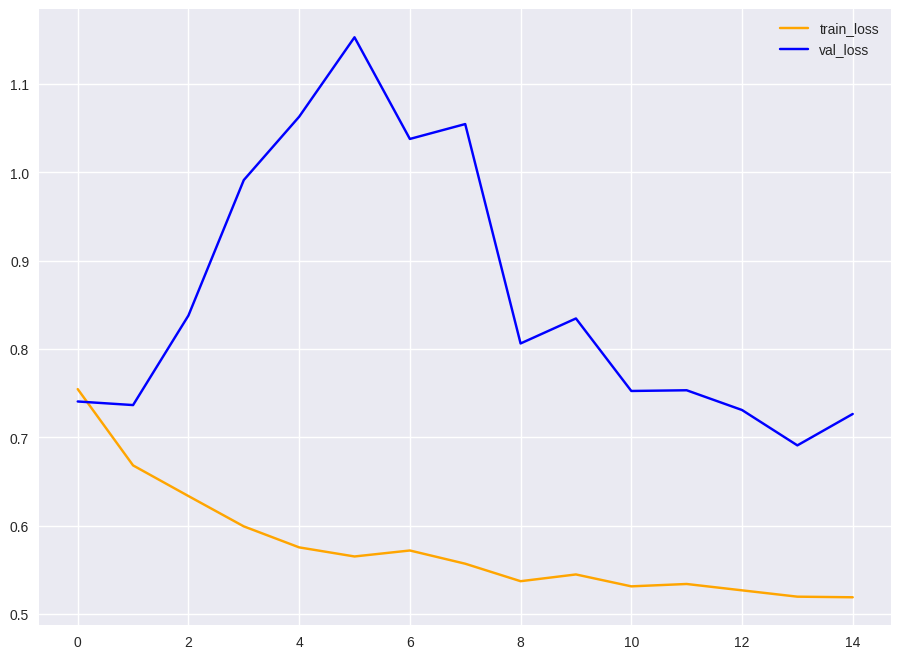

In [60]:
plt.style.use('seaborn')
plt.figure(figsize = (11, 8))
plt.plot(h.history['loss'], c = 'orange', label = 'train_loss')
plt.plot(h.history['val_loss'], c = 'blue', label = 'val_loss')
plt.legend()
plt.show()

<ipython-input-61-eec54a2f5362>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


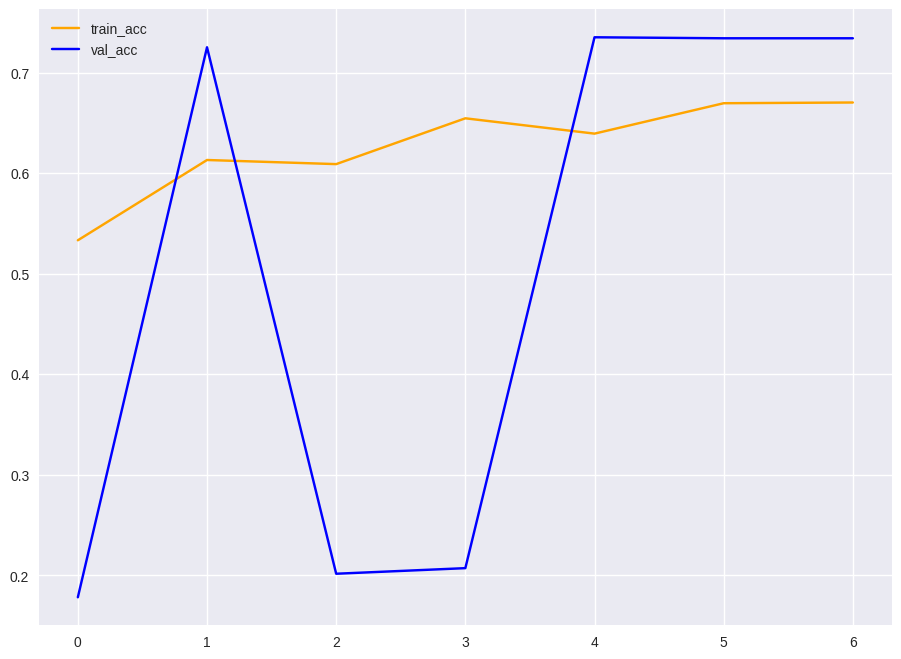

In [61]:
plt.style.use('seaborn')
plt.figure(figsize = (11, 8))
plt.plot(history.history['accuracy'], c = 'orange', label = 'train_acc')
plt.plot(history.history['val_accuracy'], c = 'blue', label = 'val_acc')
plt.legend()
plt.show()

# Predict

In [62]:
images_predict = model.predict(np.array(test_imgs))

1/1 [==============================] - 5s 5s/step


In [63]:
def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize = (12, 12))
    ax[0].set_title("Origin")
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")

    ax[1].set_title("Predict")
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")

    ax[2].set_title("Ground truth")
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

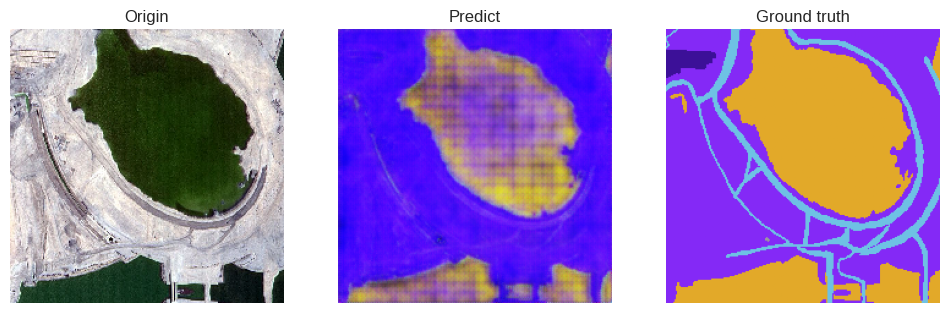

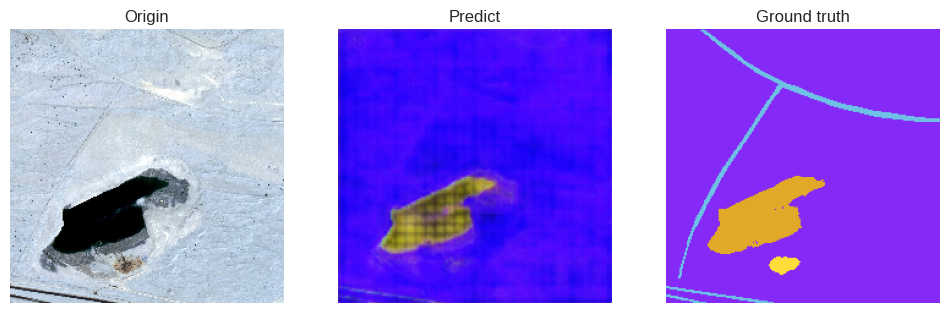

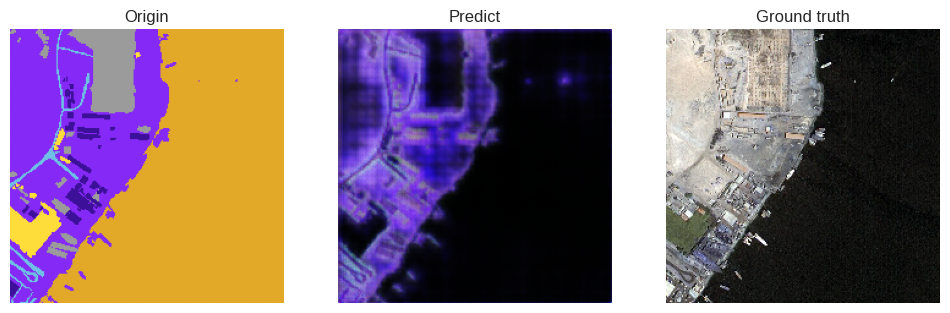

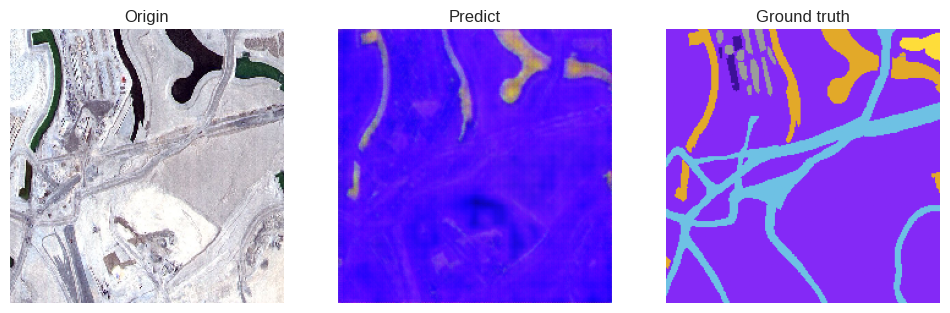

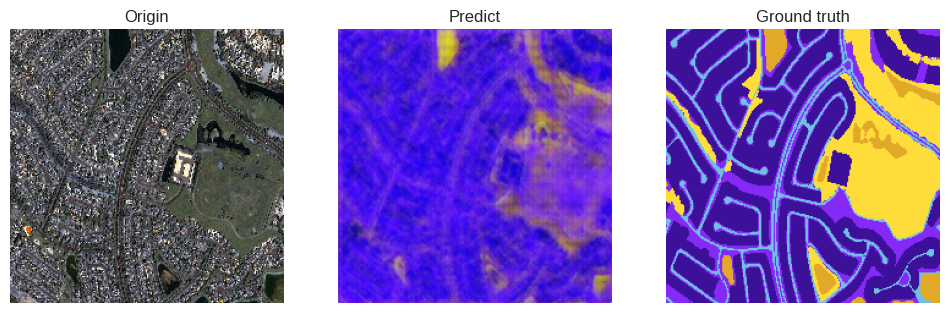

In [64]:
for id in range(5):
    show_result(id)